<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Лемматизация-и-очистка" data-toc-modified-id="Лемматизация-и-очистка-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Лемматизация и очистка</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Выборки-для-обучения" data-toc-modified-id="Выборки-для-обучения-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Выборки для обучения</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# <center> Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Install spaCy (run in terminal/prompt)
import sys
!{sys.executable} -m pip install spacy
# Download spaCy's  'en' Model
!{sys.executable} -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 2.1 MB/s eta 0:00:0000:0100:01m
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
!/opt/conda/bin/python -m pip install wordcloud==1.8.2.2  
!pip install --upgrade Pillow  (попробуй версию 9.5.0)


zsh:1: no such file or directory: /opt/conda/bin/python
zsh:1: unknown file attribute: ^


In [4]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [5]:
import re
import nltk
import pandas as pd
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import spacy
from nltk.probability import FreqDist
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [6]:
#nltk.download('punkt')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
tqdm.pandas()

In [7]:
# Функция оставит только буквы
def clear(text):
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    return ' '.join(text.split())
# Лемматизация

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
def lemmatize(text):
    #m = WordNetLemmatizer()
    #txt_list =  nltk.word_tokenize(text)
    #return ' '.join([m.lemmatize(word) for word in txt_list])
    
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

## Подготовка

In [8]:

try:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

display(df.head(3))
display(df.info())
RANDOM_STATE = 42
TEST_SIZE = 0.1

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0


<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

In [9]:
display(df.duplicated().sum())
display(df['toxic'].value_counts())

0

toxic
0    143106
1     16186
Name: count, dtype: int64

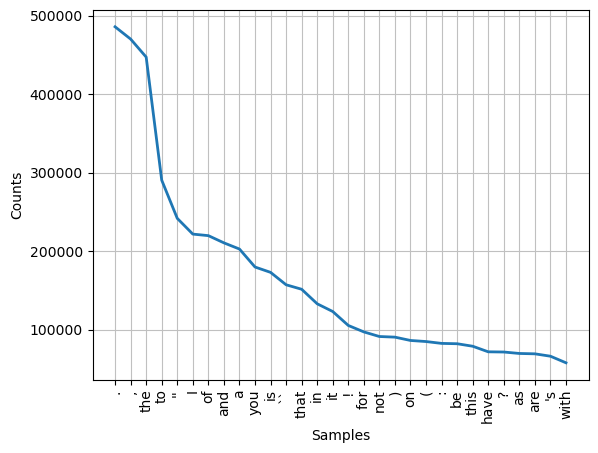

In [10]:
# Объединяем все тексты в один текст
all_text = ' '.join(df['text'])

# Токенизируем текст
tokens = nltk.word_tokenize(all_text)

# Создаем частотное распределение
fdist = FreqDist(tokens)

# Строим график частотного распределения для 30 самых частотных слов
fdist.plot(30, cumulative=False)
plt.show()

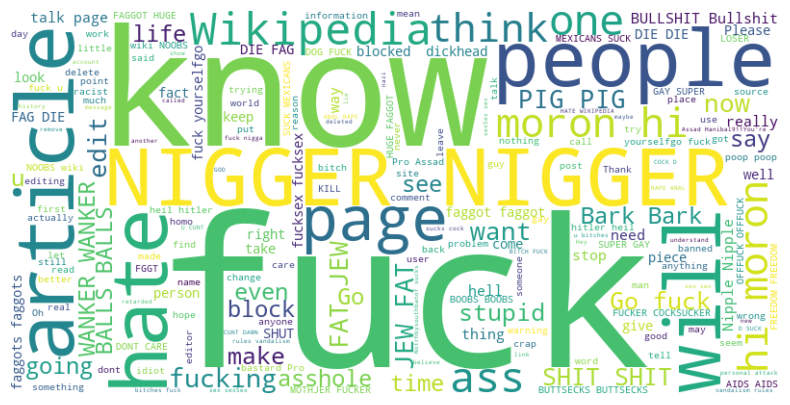

In [18]:

%matplotlib inline

# Объединение всех текстов в одну строку
text_1 = df.query('toxic==1')
text_raw1 = " ".join(text_1['text'])

# Создание облака слов
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_raw1)

# Отображение облака слов
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Отключаем оси
plt.show()

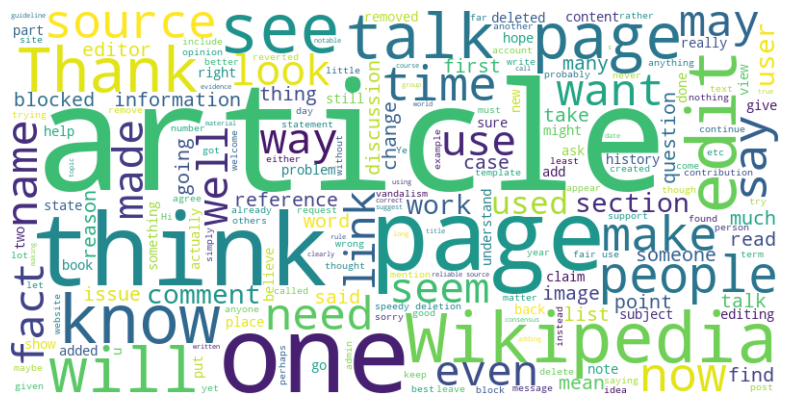

In [20]:

%matplotlib inline
text_0 = df.query('toxic==0')
text_raw0 = " ".join(text_0['text'])
# Создание облака слов
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_raw0)

# Отображение облака слов
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Отключаем оси
plt.show()

### Лемматизация и очистка


In [23]:
df['lemm_text'] = df['text'].astype(str).progress_apply(lambda x: lemmatize(clear(x)))

  0%|          | 0/159292 [00:00<?, ?it/s]

In [24]:
df.to_csv('/Users/jigo/Downloads/limma.csv') #сохранил в файл

In [25]:
df=pd.read_csv('/Users/jigo/Downloads/limma.csv', index_col=0)
df.head(5)  # загружаю

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,D'aww he match this background colour I be see...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I be really not try to edit war it be ...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can not make any real suggestion on imp...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


### Вывод ###

- Выполнили загрузку данных 
- Тексты на английском языке
- Дубликатов не обнаружили
- Форматы столбцов верные 
- Написал функцию для лемматизации и очистки с использованием spacy
- Выполнил лемматизацию и очистку текста для обучения

In [26]:
df.isna().sum()
df[df.isna().any(axis=1)]
df= df.dropna(subset=['lemm_text'])

## Выборки для обучения

In [27]:
train, test = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=df['toxic'])

y_train = train['toxic']
X_train = train['lemm_text']

y_test = test['toxic']
X_test = test['lemm_text']

display(df.shape)
display(X_train.shape)
display(X_test.shape)

(159282, 3)

(143353,)

(15929,)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159282 entries, 0 to 159450
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       159282 non-null  object
 1   toxic      159282 non-null  int64 
 2   lemm_text  159282 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.9+ MB


## Обучение

In [29]:
stop_words = set(stopwords.words('english'))
pipe_final = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=list(stop_words))),
    ('models', LogisticRegression(
        random_state=RANDOM_STATE, 
        solver='liblinear', 
        class_weight='balanced'))
])

# Определяем сетку параметров
param_grid = [
    # Параметры для TfidfVectorizer и RandomForestRegressor
    {   
        'tfidf__max_df': [0.75, 1.0],
        'tfidf__min_df': [1, 5],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(50, 250),
        'models__max_depth': range(10, 40),
        'models__max_features': range(1, 10)
    },

    # Параметры для TfidfVectorizer и LogisticRegression
    {
        'tfidf__max_df': [0.75, 1.0],
        'tfidf__min_df': [1, 5],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            class_weight='balanced'
        )],
        'models__C': range(1, 12),
        'models__penalty': ['l1', 'l2'],
        'models__max_iter': range(50, 200)
    },

    # Параметры для TfidfVectorizer и CatBoostClassifier
    {   
        'tfidf__max_df': [0.75, 1.0],
        'tfidf__min_df': [1, 5],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'models': [CatBoostClassifier(
            random_state=RANDOM_STATE, 
            verbose=False, 
            eval_metric='F1', 
            learning_rate=0.1
        )],
        'models__iterations': range(10, 100),
        'models__max_depth': [10, 20, 30]
    },

    # Параметры для TfidfVectorizer и LGBMClassifier
    {   
        'tfidf__max_df': [0.75, 1.0],
        'tfidf__min_df': [1, 5],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        'models': [LGBMClassifier(
            random_state=RANDOM_STATE,
            learning_rate=0.1,
            class_weight='balanced'
        )],
        'models__max_depth': range(1, 10), 
        'models__num_leaves': range(10, 100),
        'models__n_estimators': range(100, 1000)
    }
]


In [30]:
# Используем RandomizedSearchCV для настройки гиперпараметров
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=3,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train.astype('str'), y_train)

# Отображаем результаты
print("Лучшие параметры: ", randomized_search.best_params_)
print("Лучший результат: ", randomized_search.best_score_)

[LightGBM] [Info] Number of positive: 9711, number of negative: 85858
[LightGBM] [Info] Number of positive: 9710, number of negative: 85858
[LightGBM] [Info] Number of positive: 9711, number of negative: 85858
[LightGBM] [Info] Number of positive: 9710, number of negative: 85858
[LightGBM] [Info] Number of positive: 9711, number of negative: 85858
[LightGBM] [Info] Number of positive: 9710, number of negative: 85858
[LightGBM] [Info] Number of positive: 9711, number of negative: 85858
[LightGBM] [Info] Number of positive: 9711, number of negative: 85858
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 6.616798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 438800
[LightGBM] [Info] Number of data points in the train set: 95569, number of used features: 8348
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[Li

/Users/jigo/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [31]:
predictions = randomized_search.best_estimator_.predict(X_test)
lin_f1 = f1_score(y_test, predictions)
display(lin_f1)

0.7626972740315638

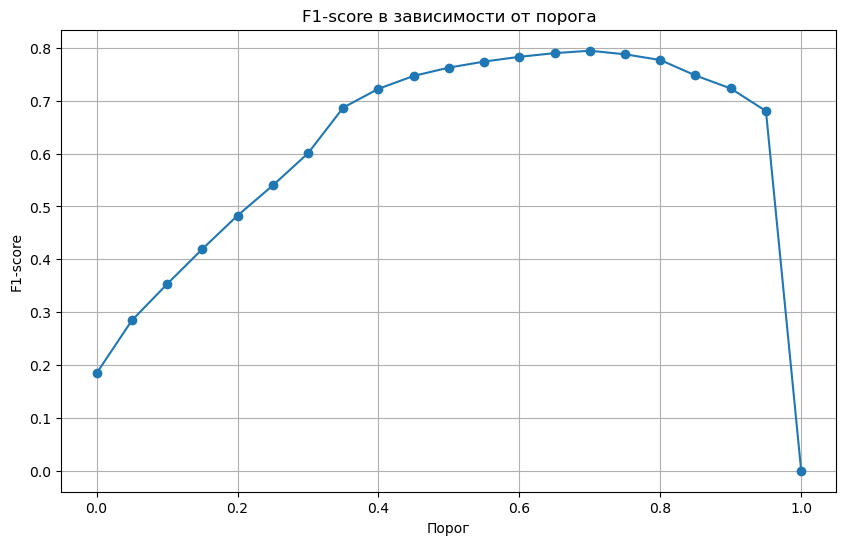

Лучший порог: 0.7000000000000001
Лучший F1-score: 0.7946282345234196


In [33]:
# вероятности предсказаний
probabilities = randomized_search.best_estimator_.predict_proba(X_test)[:, 1]

# диапазон порогов
thresholds = np.arange(0.0, 1.05, 0.05)

# F1-score для каждого порога
f1_scores = [f1_score(y_test, (probabilities >= threshold).astype(int)) for threshold in thresholds]

# график
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, marker='o')
plt.title('F1-score в зависимости от порога')
plt.xlabel('Порог')
plt.ylabel('F1-score')
plt.grid(True)
plt.show()

# лучший порог и соответствующий F1-score
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

print(f'Лучший порог: {best_threshold}')
print(f'Лучший F1-score: {best_f1_score}')

In [34]:
# Применение лучшего порога
predictions = (probabilities >= best_threshold).astype(int)

# Вычисление окончательной метрики
final_f1_score = f1_score(y_test, predictions)

print(f'Окончательный F1-score при лучшем пороге: {final_f1_score}')

Окончательный F1-score при лучшем пороге: 0.7946282345234196


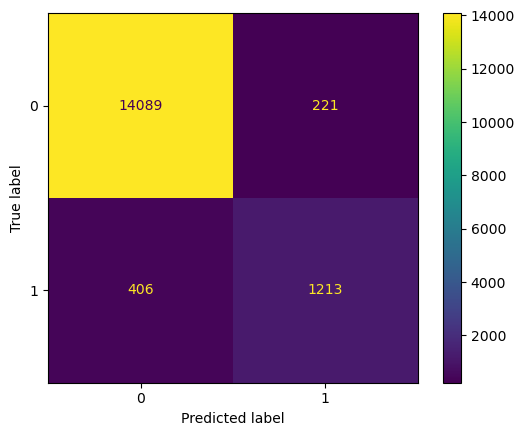

In [35]:
cm = confusion_matrix(y_test, predictions, labels=randomized_search.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=randomized_search.best_estimator_.classes_)
disp.plot()
plt.show()

## Выводы

- Выпонили настройку паплайна на 4 разных модели классификации
- подобрали гиперпараметры и выбрали лучшую модель, 
Лучшие параметры и модель :  {'models__penalty': 'l1', 'models__max_iter': 193, 'models__C': 3, 'models': LogisticRegression(class_weight='balanced',     random_state=42, solver='liblinear')}
Лучшая метрика на обучающей выборке:  0.762

- применили выбранную модель на тестовые данные и получили метрику на тестовой выборке 0.79 - что является вышего целевого 0.75
- также построили матрицу конфузов, видим что 

        - истинноотрицательных результатов: 14089
        - ложноотрицательных результатов: 406
        - истинноположительных результатов: 1213
        - ложноположительных результатов: 221

- это говорит о том, что модель довольно хорошо определяет плохие комментарии, при этом модель ошибается чаще присваивая 1 при истинном 0 
